# Продвинутый Python, лекция 5

**Лектор:** Петров Тимур

**Семинаристы:** Бузаев Федор, Дешеулин Олег, Садуллаев Музаффар, Коган Александра, Васина Олеся

**Spoiler Alert:** в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)

## Асинхронность

Давайте начнем с жизненной аналогии, что есть асинхронность.

Ситуация такая: тебе нужно поехать на важную встречу, а по пути ты хочешь ответить на письма, полистать тикток и позвонить другу (**асинхронно**).

Если бы ты делал это последовательно (**синхронно**), ты бы сначала заказал такси, сел в него, дождался конца поездки, а только потом начал бы отвечать на письма, читать новости и звонить другу. Всё это заняло бы больше времени, и некоторые задачи пришлось бы делать уже после поездки.

Давайте разделим понятия синхронности и асинхронности

1. **Синхронный запрос** блокирует выполнение программы до тех пор, пока не получит ответ, что может привести к простою. В такие моменты программа ничего не делает, ожидая завершения операции, что неэффективно, особенно если ожидание длительное.

2. **Асинхронный запрос** позволяет программе продолжать выполнение других задач, не дожидаясь ответа. Это происходит благодаря "переключению контекста". Во время выполнения асинхронного запроса программа может временно приостановить его и заняться другими задачами. Когда ответ приходит, программа возвращается к приостановленной задаче и продолжает её выполнение.

Что такое асинхронность? Представим себе программу, которая запрашивает данные на каком-либо сервере. Отправляется запрос... ждем ... ждем ... и получаем ответ.

Что происходит в момент ожидания? Ничего, мы просто ждем результата. А вообще было бы классно не тратить время попусту (как и ресурсы), а делать что-то еще (как будто наше ожидание происходит на фоне). В этом и суть асинхронности!

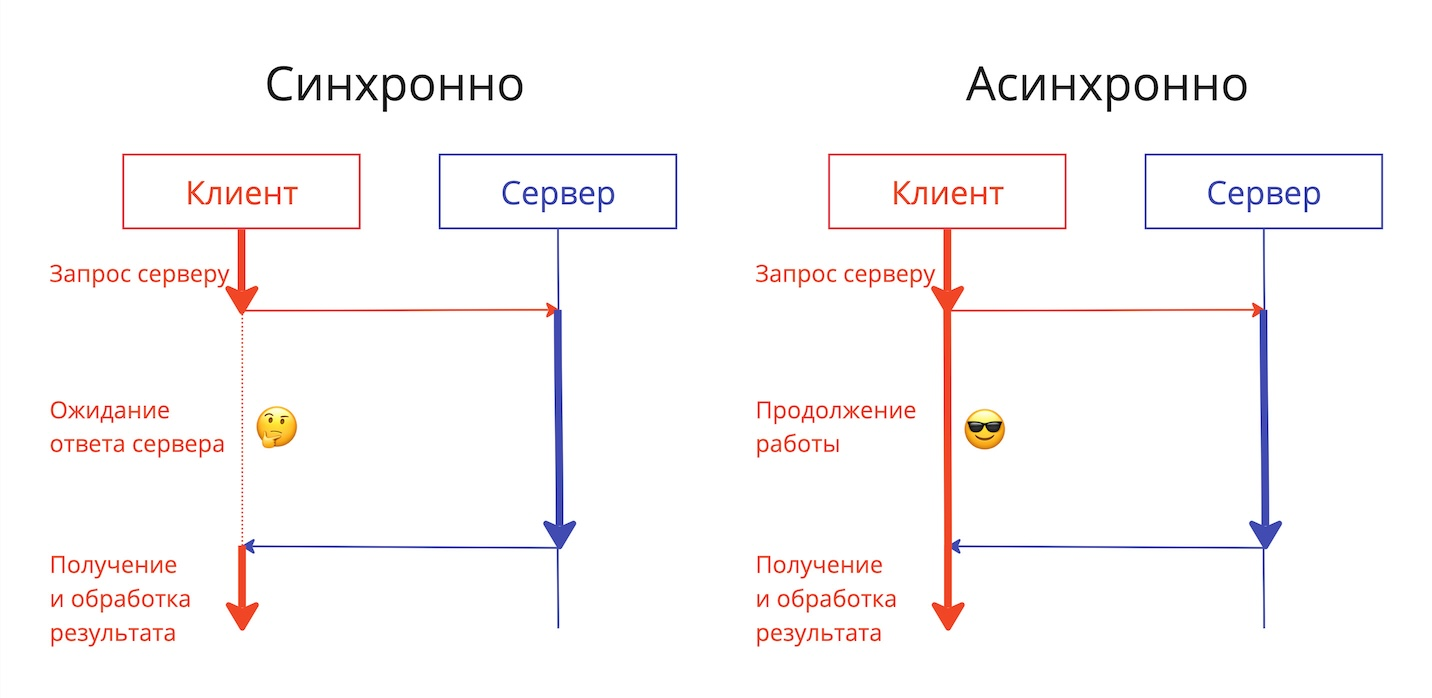

Важное отличие асинхронного программирования и многопоточного. Асинхронное программирование позволяет выполнять несколько задач в рамках одного потока, в то время как многопоточность использует несколько потоков.

У нас есть несколько функций, которые мы вызываем, но не ожидаем результат прямо сейчас. Внутри асинхронного программирования - идея конкурентности (concurrency) — две или более задачи могут запускаться, выполняться и завершаться в перекрывающиеся периоды времени.

Для этого в Python есть библиотека [asyncio](https://docs.python.org/3/library/asyncio.html), которая основана на корутинах.

Корутины - это некоторая функция, которая может начинаться, приостанавливаться и завершаться в произвольный момент времени. Они позволяют контролировать моменты своей приостановки и возобновления работы, что делает их идеальными для сценариев асинхронного программирования, например, при выполнении длительных задач, ожидании данных от внешних ресурсов или выполнении других корутин.

Давайте на примере:

In [ ]:
import asyncio

async def compute(a, b):
    print('Compute...')
    await asyncio.sleep(1.0)
    return a + b

async def print_sum(a, b):
    result = await compute(a, b)
    print(f'{a} + {b} = {result}')

In [ ]:
async def main():
    a, b = 1, 2
    result = await compute(a, b)
    print(f'{a} + {b} = {result}')

await main()

Compute...
1 + 2 = 3


Что здесь происходит?

Мы создали две корутины, `compute()` и `print_sum()` (указывается с помощью слова `async`)

Далее мы запустили наше выполнение с помощью так называемого `event_loop`, который берет нашу функцию, и запускает ее.

В свою очередь, наша корутина `compute()` запускается и находится в режиме ожидания, пока не выполнится `compute()` (это делается с помощью слова `await`). После ожидания в секунду, `compute()` выводит ответ, который передается к `print_sum()` (напоминаю, все это время `print_sum()` выполняется) и далее выводит ответ.

Общая схема выглядит вот так:

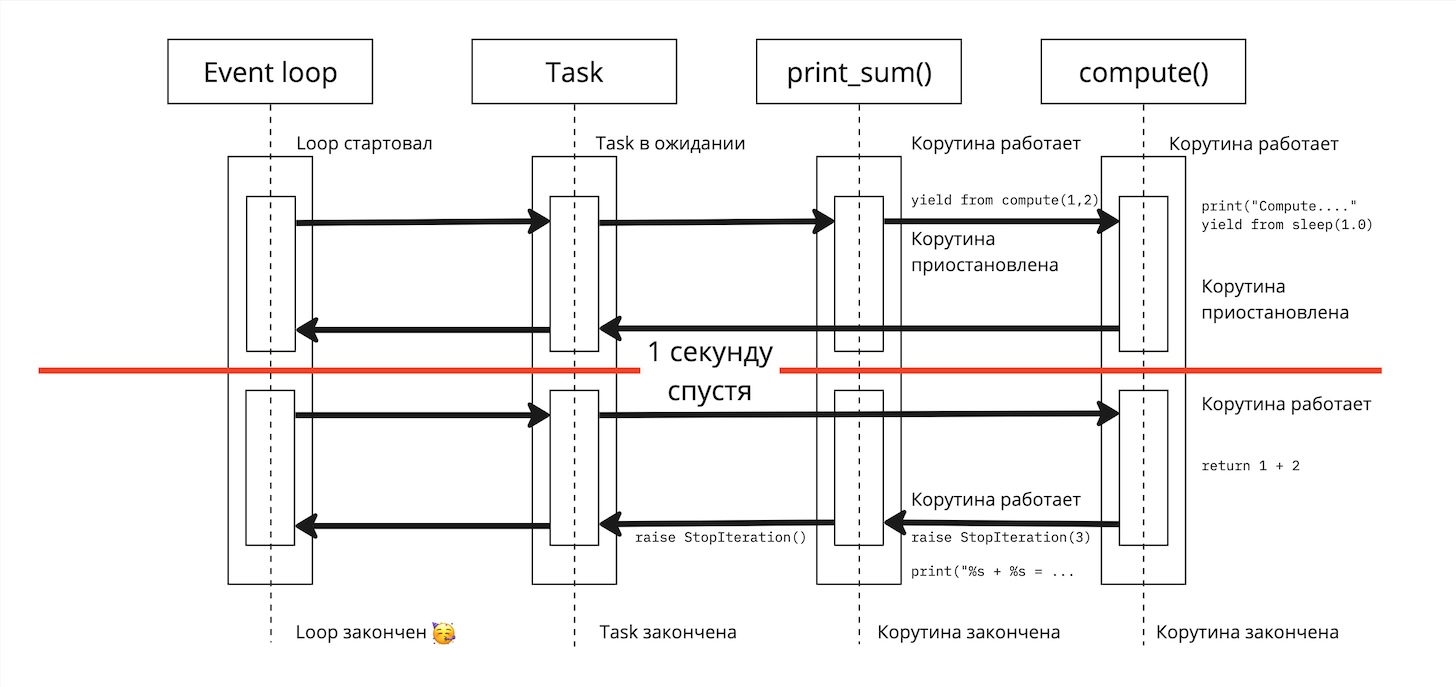

Понятное дело, что сейчас собрали такой игрушечный пример (какой сейчас был смысл так сделать). Но таким образом можно запустить выполнение и ждать результата, например, от нескольких функций etc. Давайте на вот таком примере:

In [ ]:
import asyncio

async def factorial(name, number):
    f = 1
    for i in range(2, number + 1):
        print(f"Task {name}: Compute factorial({i})...")
        await asyncio.sleep(1)
        f *= i
    print(f"Task {name}: factorial({number}) = {f}")
    return f

res = await asyncio.gather(
    factorial("A", 2),
    factorial("B", 3),
    factorial("C", 4),
    return_exceptions= True # как обрабатывать ошибки, если что-то упадет
)
print(res)


/usr/lib/python3.10/tokenize.py:527: RuntimeWarning: coroutine 'main' was never awaited
  pseudomatch = _compile(PseudoToken).match(line, pos)


Task A: Compute factorial(2)...
Task B: Compute factorial(2)...
Task C: Compute factorial(2)...
Task A: factorial(2) = 2
Task B: Compute factorial(3)...
Task C: Compute factorial(3)...
Task B: factorial(3) = 6
Task C: Compute factorial(4)...
Task C: factorial(4) = 24
[2, 6, 24]


Что у нас происходит здесь и что добавилось?

* gather - запусти все, что мы перечислили, асихнронно

Что мы видим по выводу?

У нас есть таска A, B, C. В линейной логике мы бы вначале посчитали A, потом B, потом C (и все время ожидания сложилось бы). Как это здесь работает?

Идем в задачу A, что-то сделали, уходим в режим ожидания. Пока ожидаем, можно взять и что-то сделать в таске B, уходим, можем сделать что-то в таске С. Дождались внутри A, делаем ее и так далее. Таким образом, мы делаем 3 таски в одно время

![](https://pythonru.com/wp-content/uploads/2021/05/ispolzovanii-asinhronnosti.png)

### Ограничение ожидания

Отлично, можем делать что-то асинхронно, но что, если у нас один из вызовов затупил настолько, что мы не хотим ждать и пойти делать дальше что-то без него (скажем, какой-то сервер упал, ответа от него мы не дождемся)?

Для этого есть timeout - ограничение на время ответа

In [ ]:
import asyncio

async def eternity():
    await asyncio.sleep(3600)
    print('yay!')


# Wait for at most 1 second
try:
    await asyncio.wait_for(eternity(), timeout=1.0) # Отдельная функция wait_for, то есть ждем функцию, но ограничиваем по времени
except asyncio.TimeoutError: # если выплюнул ошибку ожидания, то делаем то или иное
    print('timeout!')


timeout!


Что происходит на уровне корутины? Он ловит ошибку, убивается и закрывается. Но внутри той же самой корутины можно сделать что-то еще с этой ошибкой (и это нормально)

In [ ]:
import asyncio

async def eternity():
    try:
        await asyncio.sleep(3600)
        print('yay!')
    except asyncio.CancelledError:
        print("closed")
        await asyncio.sleep(5)

# Wait for at most 1 second
try:
    await asyncio.wait_for(eternity(), timeout=1.0) # Отдельная функция wait_for, то есть ждем функцию, но ограничиваем по времени
except asyncio.TimeoutError: # если выплюнул ошибку ожидания, то делаем то или иное
    print('timeout!')


closed
timeout!


А ежели мы хотим сделать так, чтобы она все-таки доработала, но скинула ошибку того, что она работает долго? На этот случай есть shield (защита от отмены таска):

In [ ]:
import asyncio

async def eternity():
    await asyncio.sleep(5)
    print('yay!')

# Wait for at most 1 second
try:
    await asyncio.wait_for(asyncio.shield(eternity()), timeout=1.0) # Отдельная функция wait_for, то есть ждем функцию, но ограничиваем по времени
except asyncio.TimeoutError: # если выплюнул ошибку ожидания, то делаем то или иное
    print('timeout!')
    await asyncio.sleep(5)

timeout!
yay!


### Таски

У нас есть ожидание, есть запуски и так далее. А нельзя это как-то обернуть в сущность типа задачи, которую можно вызвать позже сразу как результат? Можно! Для этого есть объект Task, который создается с помощью функции create_task() (и отсчет начинается уже в момент создания таски):

In [ ]:
import asyncio
import time

async def say(word, delay):
    print("heh" + word)
    await asyncio.sleep(delay)
    print(word)

t_1 = asyncio.create_task(say("Hi_1", 2))
t_2 = asyncio.create_task(say("Hi_2", 1))

print(time.strftime("%X"))

await t_1
await t_2

print(time.strftime("%X"))

16:41:22
hehHi_1
hehHi_2
Hi_2
Hi_1
16:41:24


### Забираем результаты как придут

Хорошо, у нас есть несколько корутин, умеем запускать с помощью gather, а как сразу забирать результаты, не ожидая окончания каждого из них? На это есть as_completed:

In [ ]:
async def fact(number):
    res = 1
    for i in range(2, number + 1):
        await asyncio.sleep(1)
        res *= i
    return number, res

for i, future in enumerate(asyncio.as_completed([fact(4), fact(3), fact(2)])):
    number, result = await future
    print(f"Factorial({number}) = {result}")

Factorial(2) = 2
Factorial(3) = 6
Factorial(4) = 24


## Комбинируем потоки и корутины

Зачем это нужно?

Допустим, что вы настраиваете работу системы, допустим, системы доставки. Вам что необходимо? Вы ждете заказов от пользователя, но пока вы их ждете, то у вас же все не простаивает на месте: заказы собираются, курьеры возят. И все это синхронно. Давайте осуществлять мечту

In [ ]:
import time
import asyncio


def blocking_io():
    print(f"{time.strftime('%X')} block IO")
    time.sleep(5) # снимает GIL
    print(f"{time.strftime('%X')} unblock IO")

non_block = asyncio.to_thread(blocking_io) # без скобочек!!! аргументы просто через пробел, версия 3.9+

async def main():
    print(f"{time.strftime('%X')} start async")
    _ = await asyncio.gather(non_block, asyncio.sleep(5))
    print(f"{time.strftime('%X')} finish async")

asyncio.run(main())

Аналогично с теми же самими факториалами (опять-таки, это нам не даст ускорения по сравнению с просто корутинами, потому что слишком малые рассчеты) и опять-таки - внутри Python паралеллить вычисления - дело такое себе

In [ ]:
import time
import asyncio

def factorial(name, number):
    f = 1
    for i in range(2, number + 1):
        print(f"Task {name}: Compute factorial({i})...")
        time.sleep(0.1)
        f *= i
    print(f"Task {name}: factorial({number}) = {f}")
    return f


fact_1 = asyncio.to_thread(factorial, "A", 2)
fact_2 = asyncio.to_thread(factorial, "B", 3)
fact_3 = asyncio.to_thread(factorial, "C", 4)

async def main():
    print(f"{time.time()} beg")
    res = await asyncio.gather(
        fact_1,
        fact_2,
        fact_3
    )
    print(f"{time.time()} end")

asyncio.run(main())

RuntimeError: asyncio.run() cannot be called from a running event loop

## IO bound

Аналогия из жизни для IO bound операций — это ожидание в ресторане. Представь, что ты пришёл в ресторан, сделал заказ, и теперь ждёшь, пока приготовят еду.

Ты уже сделал всё, что мог: выбрал блюдо, сказал официанту, и теперь ты просто сидишь и ждёшь. Кухня в это время готовит заказ, но ты не можешь ускорить процесс или сделать что-то, чтобы еда быстрее попала к тебе. Всё, что тебе остаётся — это ждать, пока еда будет готова и её принесут.

Весь этот процесс — это внешняя операция, которая требует времени на выполнение и не зависит напрямую от тебя.

В сокращении IO bound, I/O означает Ввод/Вывод, а bound переводится как ограниченный. Таким образом, IO bound задачи — это те задачи, для которых основное время выполнения определяется операциями ввода/вывода. Примеры таких задач включают чтение или запись файлов, отправку и получение данных по сети, взаимодействие с пользователем и другие. Если ваша программа тратит больше времени на ожидание завершения этих операций, чем на выполнение вычислений, значит, она ограничена именно операциями ввода-вывода.

Примеры I/O bound операций:

1. Взаимодействие с пользователем: Это может включать в себя чтение ввода с клавиатуры или вывод информации на экран.


```
# Чтение ввода с клавиатуры
name = input('Insert your name: ')

# Вывод информации на экран
print(f'Hello, Dear {name}!')

```

2. Взаимодействие с базами данных: Это может включать в себя чтение и запись данных в базу данных, выполнение SQL-запросов, транзакций и так далее.

```
import sqlite3

# Подключение к базе данных
conn = sqlite3.connect('stocks.db')

# Создание курсора
curs = conn.cursor()

# Выполнение SQL-запроса
curs.execute("SELECT * FROM stocks WHERE symbol = 'YDEX'")
```
3. Сетевые операции, взаимодействие с API: Это включает в себя отправку и получение данных по сети. Это может быть общение с веб-сервером, обмен данными между клиентом и сервером или даже чтение и запись данных в базу данных.

```
import requests

# Отправка GET запроса
response = requests.get('http://www.python.org')

# Отправка POST запроса
response = requests.post('http://www.python.org', data={'key':'value'})
```

4. Чтение и запись файлов: Это самые общие примеры IO операций. Когда вы открываете файл для чтения или записи, вы выполняете IO операцию.

```
# Чтение файла
with open('file.txt', 'r') as f:
    data = f.read()

# Запись в файл
with open('file.txt', 'w') as f:
    f.write('Hello, World!')
```

## CPU bound

CPU bound задачи – это те задачи, которые ограничены скоростью процессора, поскольку основное время выполнения тратится на интенсивные вычисления, а не на ввод/вывод.

Представьте, что вы сталкиваетесь с трудной задачей по python (tree?). Время, которое Вы потратите на её решение, будет похоже на ситуацию с CPU bound. Почему? Потому что вы будете интенсивно задействовать свои мозговые ресурсы — умственные способности, чтобы найти решение. Этот процесс требует активного мышления, ведь именно от Вашей способности быстро и эффективно обрабатывать информацию зависит, как быстро Вы справитесь с задачей.

Примеры CPU bound задач:

1. Циклы: Циклы, такие как for и while, требуют активного использования процессора для итерации по элементам или выполнения повторяющихся действий.



```
# Цикл while
i = 0
while i < 1337:
    print(i)
    i += 1


# Цикл for
for i in range(1337):
    print(i)
```

2. Обработка изображений и видео включает фильтрацию, изменение размеров, конвертацию форматов, кодирование и декодирование видео, требующие значительных ресурсов процессора. (все мы хотим красивые фоточки в инсте)

```
from PIL import Image, ImageFilter

# Открытие изображения
img = Image.open('image.jpg')

# Применение фильтра
img = img.filter(ImageFilter.BLUR)

# Сохранение изображения
img.save('blurred_image.jpg')
```

3. Арифметические и логические операции: Это включает в себя операции сложения, вычитания, умножения, деления, возведения в степень, а также операции сравнения и логические операции (and, or, not).

```
# Арифметические операции
result = 1337 / 12 * 2 / (7 + 12%2)

# Логические операции
true_mask = [a > b] and [b < c]
```




## А где работать с асихнронностью?

## aiofiles

aiofiles — это библиотека для асинхронной работы с файлами в Python. Она позволяет читать и записывать файлы без блокировки основного потока, что особенно полезно в задачах, где требуется одновременно обрабатывать несколько файлов. Работает на базе asyncio, поддерживает стандартные операции с файлами: открытие, чтение, запись.

In [ ]:
!pip install aiofiles

In [ ]:
!wget https://raw.githubusercontent.com/VadimSmirno/count-letters-in-file-/main/test/voyna-i-mir.txt

--2024-10-06 09:16:13--  https://raw.githubusercontent.com/VadimSmirno/count-letters-in-file-/main/test/voyna-i-mir.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5353735 (5.1M) [application/octet-stream]
Saving to: ‘voyna-i-mir.txt.1’

voyna-i-mir.txt.1   100%[===================>]   5.11M  --.-KB/s    in 0.09s   

2024-10-06 09:16:13 (58.2 MB/s) - ‘voyna-i-mir.txt.1’ saved [5353735/5353735]



Асинхронное чтение файла позволяет другим асинхронным задачам продолжать выполнение, пока файл читается. Это достигается с помощью библиотеки aiofiles, которая использует asyncio для асинхронного чтения файлов.

In [ ]:
import asyncio
import aiofiles
import nest_asyncio

nest_asyncio.apply()

async def read_file_async(filename):
    async with aiofiles.open(filename, mode='r') as file:
        content = await file.read()
    return content

content = asyncio.run(read_file_async('/content/voyna-i-mir.txt'))

### Aioschedule

Первый пример - это шедулинг! Собственно, мы говорили о том, что ожидание делает работу медленнее, а наличие корутин ее ускоряет (потому что занимается чем-то еще, помимо самого ожидания)


Одна из вещей, которая очень полезна внутри асинхронности - это шедулинг (нам часто нужно что-то делать раз в какое-то время, например, раз в день нам точно надо)

In [ ]:
!pip install aioschedule

  Preparing metadata (setup.py) ... done
  Created wheel for aioschedule: filename=aioschedule-0.5.2-py3-none-any.whl size=8479 sha256=b516ad79a82809ceae31650bb3440b7ce8a31c0132960b2e432ecdf74af1b2b3
  Stored in directory: /root/.cache/pip/wheels/f5/b2/2a/ee29c2ee340b4c4552cda20998765a51eb48563c97c2bb2577
Successfully built aioschedule


Давайте на примере:

In [ ]:
import asyncio
import aioschedule as schedule
import time

async def job():
    print("HaHa")

async def new_job():
    print("Heh")

schedule.every(1).seconds.do(job) # В шедулере говорим как часто использовать и что
schedule.every(2).seconds.do(new_job)

loop = asyncio.new_event_loop()
while True:
    loop.run_until_complete(schedule.run_pending()) # запускаем loop
    time.sleep(0.1)

### Aiogram

Зачем в Телеграм боте нужна асинхронность, спросите вы? Ответ прост: это гораздо быстрее работает (особенно чем больше нагрузка, тем больше вам нужна асинхронность), ну а также это позволяет более эффективно использовать параллельность (которая, сама собой, и так есть в телеграм-боте)

В чем разница? По существу, вместо requests используется [aiohttp](https://docs.aiohttp.org/en/stable/) - асинхронная версия requests, если так можно высказаться

In [ ]:
import asyncio
import aioschedule
from telebot.async_telebot import AsyncTeleBot

API_TOKEN = '<api_token>'
bot = AsyncTeleBot(API_TOKEN)


async def beep(chat_id):
    """Send the beep message."""
    await bot.send_message(chat_id, text='Beep!')
    aioschedule.clear(chat_id)


@bot.message_handler(commands=['help', 'start'])
async def send_welcome(message):
    await bot.reply_to(message, "Hi! Use /set <seconds> to set a timer")


@bot.message_handler(commands=['set'])
async def set_timer(message):
    args = message.text.split()
    if len(args) > 1 and args[1].isdigit():
        sec = int(args[1])
        aioschedule.every(sec).seconds.do(beep, message.chat.id).tag(message.chat.id)
    else:
        await bot.reply_to(message, 'Usage: /set <seconds>')


@bot.message_handler(commands=['unset'])
def unset_timer(message):
    aioschedule.clean(message.chat.id)


async def scheduler():
    while True:
        await aioschedule.run_pending()
        await asyncio.sleep(1)


async def main():
    await asyncio.gather(bot.infinity_polling(), scheduler())


if __name__ == '__main__':
    asyncio.run(main())

Зачем еще нужна асинхронность? Опять-таки для подключения к БД. Допустим, что вы храните информацию по юзерам: как их зовут и так далее (та самая проблема, которую вы получали на ДЗ для обработки бана юзера и так далее). Так вот, для создания более сложных ботов (например, магазина), вам нужно подключаться к БД, делать асинхронного бота, и таким образом, запрос еще ждать. А остальные ждут и ждут...

## Животное дня

Итак, сегодня у нас ламы! На самом деле ламы - это 4 отдельных вида, которых стоит различать. Какие есть виды?

* Гуанако

* Викунья

* Лама

* Альпака

![](https://i.natgeofe.com/k/aadfa881-c630-4078-93b3-c75e89a42f09/guanaco-mountain.jpg)

Это гуанако. Они дикие и прыгучие, а одомашненный вид - это лама

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Black_Llama.jpg/1920px-Black_Llama.jpg)

Викунья - дикая, меньше и стройнее, чем гуанако (различить сложно)

![](https://i.artfile.ru/2048x1365_851478_[www.ArtFile.ru].jpg)

А одомашненный вид - это альпака. Она пышная и пушистая!

![](https://static.fjcdn.com/large/pictures/6d/7d/6d7d59_5574469.jpg)

Лам используют в качестве вьючных животных (но они очень гордые, положи на них больше - они пошлют)

А альпак - для того, чтобы их стричь и из шерсти делать одежду и так далее

Одомашнили примерно 5000 тыс лет назад предками инков и прочих народов Анд